# 2A.ml - Imbalanced dataset

Un jeu de données *imbalanced* signifie qu'une classe est sous représentée dans un problème de classification. Lire [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset](http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/).

In [3]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [4]:
%matplotlib inline

## Génération de données

On génère un problème de classification binaire avec une classe sous représentée.

In [5]:
import numpy.random
import pandas

def generate_data(nb, ratio, noise):
    mat = numpy.random.random((nb,2))
    noise = numpy.random.random((mat.shape[0],1)) * noise
    data = pandas.DataFrame(mat, columns=["X1", "X2"])
    data["decision"] = data.X1 + data.X2 + noise.ravel()
    vec = list(sorted(data["decision"]))
    l = len(vec)- 1 - int(len(vec) * ratio)
    seuil = vec[l]
    data["cl"] = data["decision"].apply(lambda r: 1 if r > seuil else 0)
    from sklearn.utils import shuffle
    data = shuffle(data)
    return data

data = generate_data(1000, 0.08, 0.1)
data.describe()

,X1,X2,decision,cl
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.492532,0.498356,1.039427,0.080000
std,0.286230,0.298085,0.423487,0.271429
min,0.000670,0.002242,0.068880,0.000000
25%,0.235395,0.238860,0.713504,0.000000
50%,0.481485,0.502871,1.037802,0.000000
75%,0.732724,0.754599,1.340480,0.000000
max,0.998964,0.999858,2.033590,1.000000


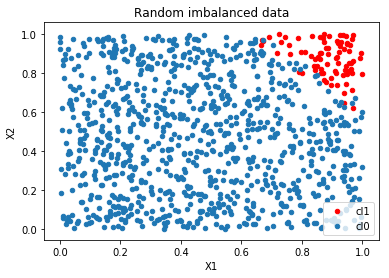

In [6]:
ax = data[data.cl==1].plot(x="X1", y="X2", kind="scatter", label="cl1", color="r")
data[data.cl==0].plot(x="X1", y="X2", kind="scatter", label="cl0", ax=ax)
ax.set_title("Random imbalanced data");

In [7]:
from sklearn.model_selection import train_test_split
while True:
    X_train, X_test, y_train, y_test = train_test_split(data[["X1", "X2"]], data["cl"])
    if sum(y_test) > 0:
        break

Le découpage apprentissage est délicat car il n'y pas beaucoup d'exemples pour la classe sous-représentée.

In [8]:
y_test.sum()

13

## Apprendre et tester un modèle

In [10]:
from sklearn.metrics import confusion_matrix

def confusion(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predt = model.predict(X_train)
    c_train = confusion_matrix(y_train, predt)
    pred = model.predict(X_test)
    c_test = confusion_matrix(y_test, pred)
    return pandas.DataFrame(numpy.hstack([c_train, c_test]), index=["y=0", "y=1"],
                            columns="train:y=0 train:y=1 test:y=0 test:y=1".split())

from sklearn.linear_model import LogisticRegression
confusion(LogisticRegression(solver='lbfgs'),
          X_train, X_test, y_train, y_test)

,train:y=0,train:y=1,test:y=0,test:y=1
y=0,683,0,237,0
y=1,29,38,5,8


Quelques exemples pour tester, quelques exemples pour apprendre. C'est peu.

In [13]:
from sklearn.tree import DecisionTreeClassifier
confusion(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)

,train:y=0,train:y=1,test:y=0,test:y=1
y=0,683,0,232,5
y=1,0,67,2,11


In [14]:
from sklearn.ensemble import RandomForestClassifier
confusion(RandomForestClassifier(n_estimators=10),
          X_train, X_test, y_train, y_test)

,train:y=0,train:y=1,test:y=0,test:y=1
y=0,683,0,232,5
y=1,0,67,3,10


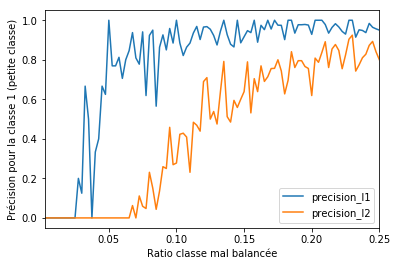

In [162]:
ratio = list(_/400.0 for _ in range(1, 101))
rows = []
for r in ratio:
    data = generate_data(1000, r, noise=0.0)
    while True:
        X_train, X_test, y_train, y_test = train_test_split(data[["X1", "X2"]], data["cl"])
        if sum(y_test) > 0 and sum(y_train) > 0:
            break
    c = confusion(LogisticRegression(penalty='l1', solver='liblinear'),
                  X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1", "test:y=0"], c.loc["y=1", "test:y=1"]
    row = dict(ratio=r, precision_l1=c1 / (c0 + c1) )
    c = confusion(LogisticRegression(penalty='l2', solver="liblinear"),
                  X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1", "test:y=0"], c.loc["y=1", "test:y=1"]
    row["precision_l2"] = c1 / (c0 + c1)
    rows.append(row)
df = pandas.DataFrame(rows)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
df.plot(x="ratio", y=[_ for _ in df.columns if _ !="ratio"], ax=ax)
ax.set_xlabel("Ratio classe mal balancée")
ax.set_ylabel("Précision pour la classe 1 (petite classe)");

La norme **l1** est plus sensible aux petites classes.

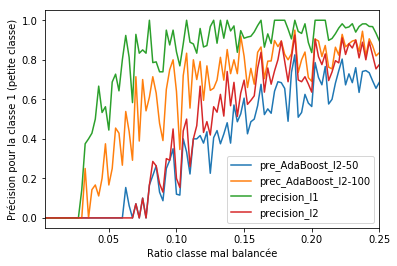

In [163]:
from sklearn.ensemble import AdaBoostClassifier
ratio = list(_/400.0 for _ in range(1, 101))
rows = []
for r in ratio:
    data = generate_data(1000, r, noise=0.0)
    while True:
        X_train, X_test, y_train, y_test = train_test_split(data[["X1", "X2"]], data["cl"])
        if sum(y_test) > 0 and sum(y_train) > 0:
            break
    c = confusion(LogisticRegression(penalty='l1', solver="liblinear"),
                  X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1", "test:y=0"], c.loc["y=1", "test:y=1"]
    row = dict(ratio=r, precision_l1=c1 / (c0 + c1) )
    c = confusion(LogisticRegression(penalty='l2', solver="liblinear"),
                  X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1", "test:y=0"], c.loc["y=1", "test:y=1"]
    row["precision_l2"] = c1 / (c0 + c1)
    c = confusion(AdaBoostClassifier(LogisticRegression(penalty='l2', solver="liblinear"),
                                     algorithm="SAMME.R", n_estimators=50,
                                     learning_rate=3),
                  X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1", "test:y=0"], c.loc["y=1", "test:y=1"]
    row["pre_AdaBoost_l2-50"] = c1 / (c0 + c1)
    c = confusion(AdaBoostClassifier(LogisticRegression(penalty='l2', solver="liblinear"),
                                     algorithm="SAMME.R", n_estimators=100,
                                     learning_rate=3),
                  X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1", "test:y=0"], c.loc["y=1", "test:y=1"]
    row["prec_AdaBoost_l2-100"] = c1 / (c0 + c1)
    rows.append(row)
df = pandas.DataFrame(rows)

fig, ax = plt.subplots(1, 1)
df.plot(x="ratio", y=[_ for _ in df.columns if _ != "ratio"], ax=ax)
ax.set_xlabel("Ratio classe mal balancée")
ax.set_ylabel("Précision pour la classe 1 (petite classe)");

On voit que l'algorithme [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) permet de favoriser les petites classes mais il faut jouer avec le learning rate et le nombre d'estimateurs.

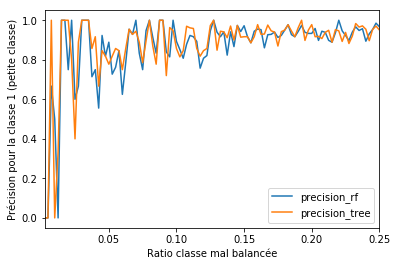

In [164]:
from sklearn.ensemble import AdaBoostClassifier
ratio = list(_/400.0 for _ in range(1, 101))
rows = []
for r in ratio:
    data = generate_data(1000, r, noise=0.0)
    while True:
        X_train, X_test, y_train, y_test = train_test_split(data[["X1", "X2"]], data["cl"])
        if sum(y_test) > 0 and sum(y_train) > 0:
            break
    c = confusion(DecisionTreeClassifier(),
                  X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1", "test:y=0"], c.loc["y=1", "test:y=1"]
    row = dict(ratio=r, precision_tree=c1 / (c0 + c1) )
    c = confusion(RandomForestClassifier(n_estimators=10),
                  X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1", "test:y=0"], c.loc["y=1", "test:y=1"]
    row["precision_rf"] = c1 / (c0 + c1)
    rows.append(row)
    
fig, ax = plt.subplots(1, 1)
df = pandas.DataFrame(rows)
df.plot(x="ratio", y=[_ for _ in df.columns if _ != "ratio"], ax=ax)
ax.set_xlabel("Ratio classe mal balancée")
ax.set_ylabel("Précision pour la classe 1 (petite classe)");

Les méthodes ensemblistes fonctionnent mieux dans ce cas car l'algorithme cherche la meilleure séparation entre deux classes de façon à ce que les deux classes soient de chaque côté de cette frontière. La proportion d'exemples a moins d'importance pour le critère de [Gini](https://fr.wikipedia.org/wiki/Coefficient_de_Gini). Dans l'exemple suivant, on trie selon la variable $X_1$ et on cherche la meilleur séparation

In [165]:
data = generate_data(100, 0.08, 0.1).values
data.sort(axis=0)
data[:5]

array([[0.00235074, 0.02527223, 0.29918622, 0.        ],
       [0.00482963, 0.04265215, 0.35695574, 0.        ],
       [0.01517114, 0.04862415, 0.39156981, 0.        ],
       [0.02612117, 0.05309787, 0.41971413, 0.        ],
       [0.02998631, 0.0679244 , 0.49516493, 0.        ]])

In [166]:
# from ensae_teaching_cs.ml.gini import gini
import numpy as np

def gini(y):
        
    y = np.array(y)
    
    p0 = (1-y).mean()
    p1 = y.mean()
    
    return  2 * p1 * p0 


def gini_gain_curve(Y):
    "le code n'est pas le plus efficace du monde mais ça suffira"
    g = gini(Y)
    curve = numpy.empty((len(Y),))
    for i in range(1, len(Y)-1):
        g1 = gini(Y[:i])
        g2 = gini(Y[i:])
        curve[i] = g - (g1 + g2) / 2
    return curve

gini_gain_curve([0, 1, 0, 1, 1, 1, 1])

array([ 5.20836364e+01,  2.69274376e-01, -1.83673469e-03,  1.85941043e-01,
        1.58163265e-01,  1.68163265e-01,  2.55640000e+02])

In [167]:
data[:, 3]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.])

In [168]:
# from ensae_teaching_cs.ml.gini import gini
gini(data[:, 3])

0.1472

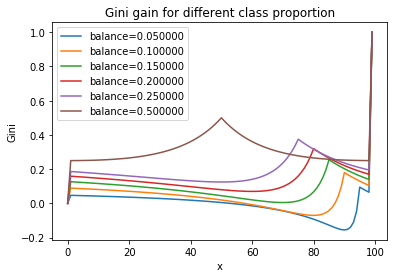

In [169]:
fig, ax = plt.subplots(1, 1)
for skew in [0.05, 0.1, 0.15, 0.2, 0.25, 0.5]:
    data = generate_data(100, skew, 0.1).values
    data.sort(axis=0)
    ax.plot(gini_gain_curve(data[:, 3]), label="balance=%f" % skew)
ax.legend()
ax.set_title("Gini gain for different class proportion")
ax.set_ylabel("Gini")
ax.set_xlabel("x");

Ce n'est pas vraiment pas l'algorithme des arbres de décision mais l'idée est de montrer que les arbres de décision sont moins sensibles aux petites classes quand il s'agit de trouver la meilleure séparation. Et c'est nécessaire car pour les branches les plus basses, tous les sous-échantillons qui terminent dans ces branches sont très mal balancés.

## Exercice 1 : réduire les exemples loin des frontières

Pour rééquilibrer la proportion des classes, on cherche à enlever des points de la base d'apprentissage pour lesquels il n'y a pas d'ambiguïté, c'est-à-dire loin des frontières. Imaginer une solution à l'aides des [k plus proches voisins](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

We have 8.0 % of positive samples in the original dataset


Training set before undersampling :


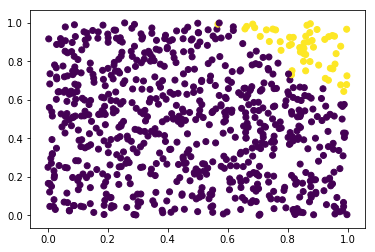

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

data = generate_data(1000, 0.08, 0.1)


print("We have {} % of positive samples in the original dataset".format(np.round(data.cl.mean(), 2)*100))

X_train, X_test, y_train, y_test = train_test_split(data[["X1", "X2"]], data["cl"])

print("\n\nTraining set before undersampling :")
plt.scatter(X_train["X1"], X_train["X2"], c=y_train)


In [18]:
test = np.random.randn(10)

test

array([-0.19402007, -0.05623966, -1.39262293, -0.23580475,  0.82256942,
       -0.49842787, -0.56389576, -0.78045003,  0.04861739, -1.15186474])

In [22]:
np.where(test > 0)

(array([4, 8], dtype=int64),)

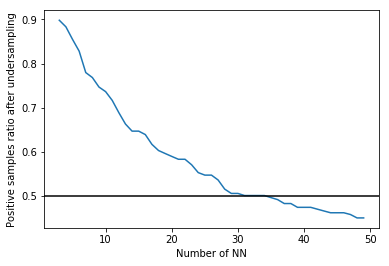

In [16]:
proportion_lst = []
nn_to_test = list(range(3, 50))

for nn in range(3, 50):
    
    kneighbors = KNeighborsClassifier(n_neighbors=nn)

    pred_proba_neighbors = kneighbors.fit(X_train, y_train).predict_proba(X_train)
    
    #We keep only the samples who don't have all their neighbors in the majority class
    to_keep_idx = np.where(pred_proba_neighbors[:, 0] < 1.)[0]

    X_train_undersampling = X_train.iloc[to_keep_idx].copy()
    y_train_undersampling = y_train.iloc[to_keep_idx].copy()
    
    proportion_lst.append(y_train_undersampling.mean())

plt.plot(nn_to_test, proportion_lst)
plt.xlabel("Number of NN")
plt.ylabel("Positive samples ratio after undersampling")
plt.axhline(0.5, c="black")



We have 50.0 % of positive samples in the new training set


Training set after undersampling :


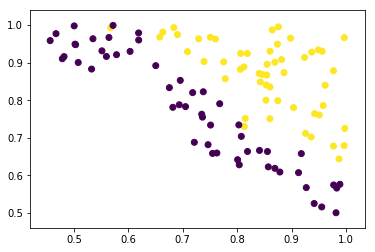

In [23]:
kneighbors = KNeighborsClassifier(n_neighbors=32)

pred_proba_neighbors = kneighbors.fit(X_train, y_train).predict_proba(X_train)

#We keep only the samples who don't have all their neighbors in the majority class
to_keep_idx = np.where(pred_proba_neighbors[:, 0] < 1.)[0]

X_train_undersampling = X_train.iloc[to_keep_idx].copy()
y_train_undersampling = y_train.iloc[to_keep_idx].copy()

print("We have {} % of positive samples in the new training set".format(np.round(y_train_undersampling.mean(), 2)*100))

print("\n\nTraining set after undersampling :")
plt.scatter(X_train_undersampling["X1"], X_train_undersampling["X2"], c=y_train_undersampling)

In [24]:
#Evaluate a LR on the 2 datasets:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score

print("###################################################################################################################")
print("CONFUSION MATRIX ON THE (UNPROCESSED TEST SET) FOR THE ORIGINAL DATASET")

print(confusion_matrix(y_test, LogisticRegression(solver="lbfgs").fit(X_train, y_train).predict(X_test)))

print("###################################################################################################################")
print("\n\n")
print("###################################################################################################################")
print("CONFUSION MATRIX ON THE (UNPROCESSED TEST SET) FOR THE UNDERSAMPLED DATASET")

print(confusion_matrix(y_test, LogisticRegression(solver="lbfgs").fit(X_train_undersampling, y_train_undersampling).predict(X_test)))

print("###################################################################################################################")

###################################################################################################################
CONFUSION MATRIX ON THE (UNPROCESSED TEST SET) FOR THE ORIGINAL DATASET
[[223   0]
 [ 17  10]]
###################################################################################################################



###################################################################################################################
CONFUSION MATRIX ON THE (UNPROCESSED TEST SET) FOR THE UNDERSAMPLED DATASET
[[223   0]
 [  2  25]]
###################################################################################################################


## Exercice 2 : multiplier les exemples

L'idée est d'utiliser une technique pour multiplier les exemples de la classe sous-représentée sans pour autant avoir des exemples exactement identiques. On utilise l'algorithme [SMOTE](http://jair.org/media/953/live-953-2037-jair.pdf). En résumé, l'algorithme consiste à créer des exemples pour la classe sous-représentée. On choisit un de ces exemples $X$. Pour cet $X$, on calcule ses $k$ plus proches voisins dans la base d'apprentissage, toutes classes comprises. On choisit un voisin aléatoire $V$ parmi les $k$ voisins. On tire un nombre aléaloire $h\in]0,1]$. Le nouvel élément ajouté à la base d'apprentissage est $X + h (V-X)$ et il est associé à la classe sous-représentée. On continue jusqu'à la proportion souhaitée.

* [SMOTE: Synthetic Minority Over-sampling Technique](http://jair.org/media/953/live-953-2037-jair.pdf)
* [Detecting Click Fraud in Online Advertising: A Data Mining Approach](http://www.jmlr.org/papers/volume15/oentaryo14a/oentaryo14a.pdf)
* [On the Statistical Consistency of Algorithms for Binary Classification under Class Imbalance](http://jmlr.org/proceedings/papers/v28/menon13a.pdf)
* [On multi-class classification through the minimization of the confusion matrix norm](http://jmlr.org/proceedings/papers/v29/Koco13.pdf)

In [10]:
X = X_train.copy()
y = y_train.copy()

In [38]:
def smote_manual(X, y, n_neighbors=5):
    
    """
    We aim at balancing the provided (binary classification) dataset
    X must be a pandas DataFrame
    y must be a pandas Series
    """    
    number_samples_byclass = y.value_counts()
    minority_y = number_samples_byclass.index[np.argmin(number_samples_byclass.values)]
    n_to_sample = np.abs(number_samples_byclass.values[0] - number_samples_byclass.values[1])
    X_to_append = np.empty((n_to_sample, X_train.shape[1]))
    y_to_append = pd.Series(np.ones(n_to_sample))
    
    #Samples of the minority class
    X_minority = X[y==minority_y].values
    
    #Fit the KNN on every sample 
    kn = KNeighborsClassifier(n_neighbors)
    kn.fit(X, y)
    
    for i in range(n_to_sample):
        
        #sample an element from the minority_class
        sample = X_minority[np.random.randint(low=0, high=X_minority.shape[0])]
        
        #select one of its NN
        random_neighbor_idx = kn.kneighbors(sample.reshape(1,-1))[1][0][np.random.randint(low=1, high=n_neighbors)]
        
        random_neighbor = X.values[random_neighbor_idx]
        
        #Create and add the synthetic element
        synth_elem = sample + np.random.rand() * (random_neighbor - sample)
        X_to_append[i] = synth_elem
    
    
    
    #Convert X_to_append to a dataframe
    X_to_append = pd.DataFrame(X_to_append, columns=X.columns)
    
    return X_to_append, y_to_append
    

New positive samples ratio after oversampling: 50.0%


Training set after oversampling :


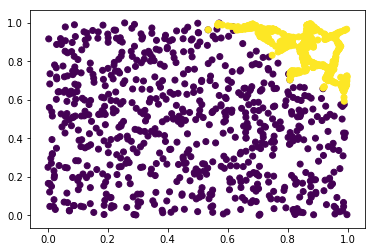

In [39]:
X_to_append, y_to_append = smote_manual(X_train, y_train)

X_train_oversampling = pd.concat((X_train, X_to_append))
y_train_oversampling = pd.concat((y_train, y_to_append))

print("New positive samples ratio after oversampling: {}%".format(100 * y_train_oversampling.mean()))

print("\n\nTraining set after oversampling :")
plt.scatter(X_train_oversampling["X1"], X_train_oversampling["X2"], c=y_train_oversampling)

In [40]:
print("###################################################################################################################")
print("CONFUSION MATRIX ON THE (UNPROCESSED TEST SET) FOR THE ORIGINAL DATASET")

print(confusion_matrix(y_test, LogisticRegression(solver="lbfgs").fit(X_train, y_train).predict(X_test)))

print("###################################################################################################################")
print("\n\n")
print("###################################################################################################################")
print("CONFUSION MATRIX ON THE (UNPROCESSED TEST SET) FOR THE OVERSAMPLED DATASET")

print(confusion_matrix(y_test, LogisticRegression(solver="lbfgs").fit(X_train_oversampling, y_train_oversampling).predict(X_test)))

print("###################################################################################################################")

###################################################################################################################
CONFUSION MATRIX ON THE (UNPROCESSED TEST SET) FOR THE ORIGINAL DATASET
[[223   0]
 [ 17  10]]
###################################################################################################################



###################################################################################################################
CONFUSION MATRIX ON THE (UNPROCESSED TEST SET) FOR THE OVERSAMPLED DATASET
[[213  10]
 [  0  27]]
###################################################################################################################


## Exercice 3 : essai du module imbalanced

Ce module implémente différentes façons de gérer les classes sous et sur représentés.

* [algorithmes implémentés](https://github.com/scikit-learn-contrib/imbalanced-learn#about)
* [exemples - imbalanced-learn](http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/index.html)

New positive samples ratio after oversampling: 50.0%


Training set after oversampling :


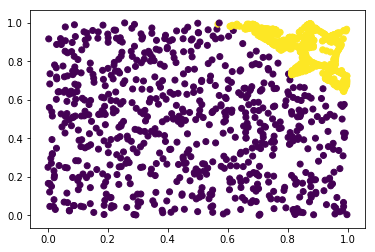

In [41]:
from imblearn.over_sampling import SMOTE

# By default, it will oversample all samples belonging to a minority class
smote = SMOTE(sampling_strategy='auto')

#WARNING : THE OUTPUT IS A NUMPY ARRAY
X_train_oversampling_smote, y_train_oversampling_smote = smote.fit_sample(X_train, y_train)

print("New positive samples ratio after oversampling: {}%".format(100 * y_train_oversampling_smote.mean()))
print("\n\nTraining set after oversampling :")
plt.scatter(X_train_oversampling_smote[:, 0], X_train_oversampling_smote[:, 1], c=y_train_oversampling_smote)

In [42]:
print("###################################################################################################################")
print("CONFUSION MATRIX ON THE (UNPROCESSED TEST SET) FOR THE ORIGINAL DATASET")

print(confusion_matrix(y_test, LogisticRegression(solver="lbfgs").fit(X_train, y_train).predict(X_test)))

print("###################################################################################################################")
print("\n\n")
print("###################################################################################################################")
print("CONFUSION MATRIX ON THE (UNPROCESSED TEST SET) FOR THE OVERSAMPLED DATASET")

print(confusion_matrix(y_test, LogisticRegression(solver="lbfgs").fit(X_train_oversampling_smote, y_train_oversampling_smote).predict(X_test)))

print("###################################################################################################################")

###################################################################################################################
CONFUSION MATRIX ON THE (UNPROCESSED TEST SET) FOR THE ORIGINAL DATASET
[[223   0]
 [ 17  10]]
###################################################################################################################



###################################################################################################################
CONFUSION MATRIX ON THE (UNPROCESSED TEST SET) FOR THE OVERSAMPLED DATASET
[[213  10]
 [  0  27]]
###################################################################################################################


## Exercice 4 : validation croisée

Lorsqu'une classe est sous représentée, la validation croisée doit être effectuée sous contrainte. Si elle est réalisée de façon complètement aléatoire, il est probable que la classe sous représentée ne soit pas présente. Si la classe 0 possède $k$ exemples parmi $N$, quelle est la distribution du minimum d'observations dans une des clasees ? Il veut comparer une crossvalidation classique avec un échantillon stratigiée ([StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)).

In [30]:
n_0 = 100
n_1 = 5
n = n_0+n_1
n_folds = 5

#Proba of at least a positive event in the first fold

p1 = 1 - (n_0/n)**(n/n_folds)
